# **ASSIGNMENT 2 - CLUSTERING**

## **Submitted by:**
- **Ladrera**, Raiken Lee
- **Tibon**, Hestia  

-----

## **1. Introduction**

@all  Assignment 2 For Clustering: Sessa Empirical Estimator
1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Deadline is this Sunday, Feb 23, 2022 at 11:59 pm
7. Do this with your thesis partner.
8. You can use any A.I. assistant.

<hr>

## **2. Exploratory Data Analysis**

### **2.1 Importing necessary packages and libraries**

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import os
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, dendrogram
from datetime import datetime

In [126]:
os.environ["OMP_NUM_THREADS"] = "1"
warnings.filterwarnings("ignore")

### **2.2 Importing the dataset**

In [127]:
# Load the dataset [The simulated data is acquired from https://github.com/Masswear/BeyondThresholds]
df = pd.read_csv("med_events.csv")

# Convert DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

### **2.3 Basic information of the dataset**

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275 entries, 0 to 2274
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   PATIENT_ID  2275 non-null   int64         
 1   DATE        2275 non-null   datetime64[ns]
 2   PERDAY      2275 non-null   int64         
 3   CATEGORY    2275 non-null   object        
 4   DURATION    2275 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 89.0+ KB


In [129]:
df.isnull().sum()

PATIENT_ID    0
DATE          0
PERDAY        0
CATEGORY      0
DURATION      0
dtype: int64

In [130]:
df.rename(columns={
    "PATIENT_ID": "pnr",
    "DATE": "eksd",
    "PERDAY": "perday",
    "CATEGORY": "ATC",
    "DURATION": "dur_original"
}, inplace=True)
df.drop(columns=["CATEGORY_ENCODED"], errors="ignore", inplace=True)
df["perday"] = df["perday"].round().astype(int)
df["dur_original"] = df["dur_original"].round().astype(int)

### **2.5 Descriptive Statistics**

In [131]:
df.describe()

,pnr,eksd,perday,dur_original
count,2275.000000,2275,2275.000000,2275.000000
mean,46.050549,2024-02-03 03:53:33.890109696,7.959560,44.778022
min,1.000000,2022-01-01 00:00:00,2.000000,20.000000
25%,23.000000,2022-11-04 00:00:00,4.000000,30.000000
50%,46.000000,2023-12-23 00:00:00,6.000000,50.000000
75%,69.000000,2025-03-06 12:00:00,8.000000,50.000000
max,100.000000,2028-10-08 00:00:00,20.000000,100.000000
std,26.366232,NaN,6.260129,16.971222


### **2.6 Look for unique values**

In [132]:
print("\nUnique Patients:", df['pnr'].nunique())
print("Unique Medication Categories:", df['ATC'].nunique())


Unique Patients: 100
Unique Medication Categories: 2


### **2.7 Distribution of numerical variables**

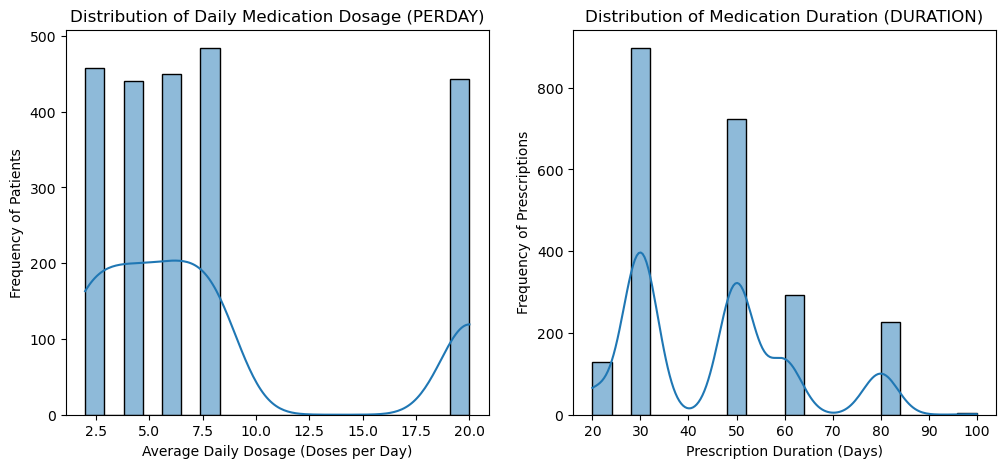

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['perday'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Daily Medication Dosage (PERDAY)')
axes[0].set_xlabel('Average Daily Dosage (Doses per Day)')
axes[0].set_ylabel('Frequency of Patients')

sns.histplot(df['dur_original'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Medication Duration (DURATION)')
axes[1].set_xlabel('Prescription Duration (Days)')
axes[1].set_ylabel('Frequency of Prescriptions')
plt.show()

### **2.8 Medication trends**

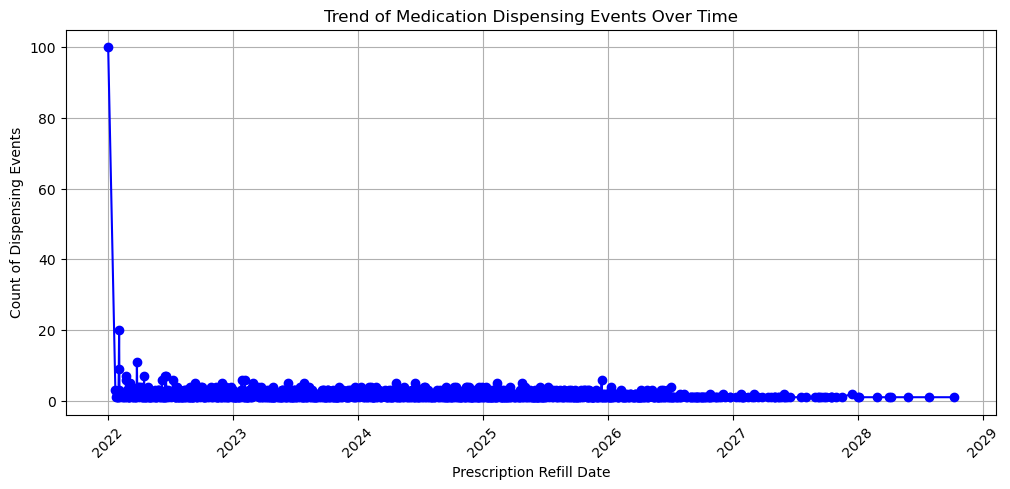

In [134]:
df_time_series = df.groupby('eksd').size()
plt.figure(figsize=(12, 5))
plt.plot(df_time_series, marker='o', linestyle='-', color='b')
plt.title('Trend of Medication Dispensing Events Over Time')
plt.xlabel('Prescription Refill Date')
plt.ylabel('Count of Dispensing Events')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### **2.8 Check for outliers**

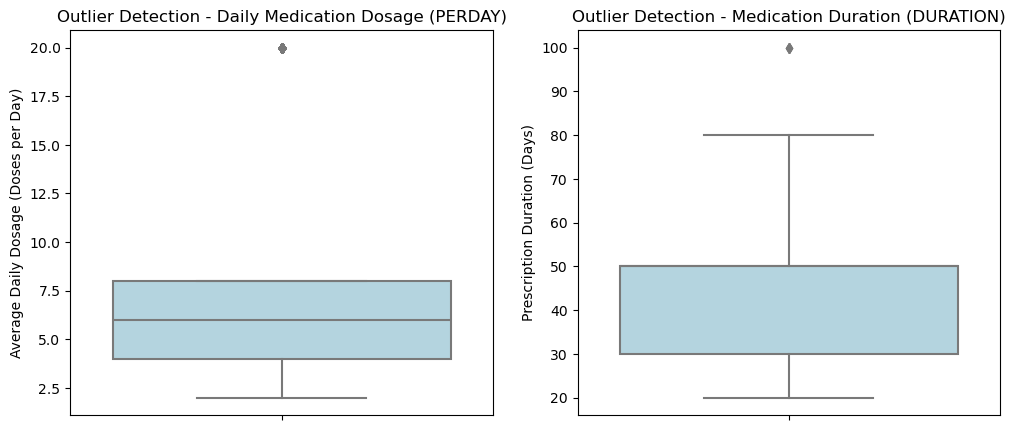

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=df['perday'], ax=axes[0], color='lightblue')
axes[0].set_title('Outlier Detection - Daily Medication Dosage (PERDAY)')
axes[0].set_ylabel('Average Daily Dosage (Doses per Day)')

sns.boxplot(y=df['dur_original'], ax=axes[1], color='lightblue')
axes[1].set_title('Outlier Detection - Medication Duration (DURATION)')
axes[1].set_ylabel('Prescription Duration (Days)')
plt.show()

### **2.9 Category distribution**

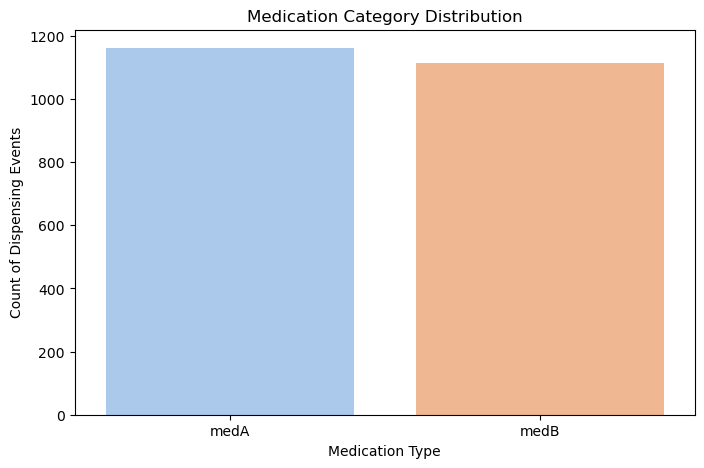

In [136]:
plt.figure(figsize=(8,5))
sns.countplot(x=df['ATC'], order=df['ATC'].value_counts().index, palette='pastel')
plt.title('Medication Category Distribution')
plt.xlabel('Medication Type')
plt.ylabel('Count of Dispensing Events')
plt.show()

In [137]:
# Encoding CATEGORY column
label_encoder = LabelEncoder()
df['CATEGORY_ENCODED'] = label_encoder.fit_transform(df['ATC'])

### **2.10 Correlation Heatmap**

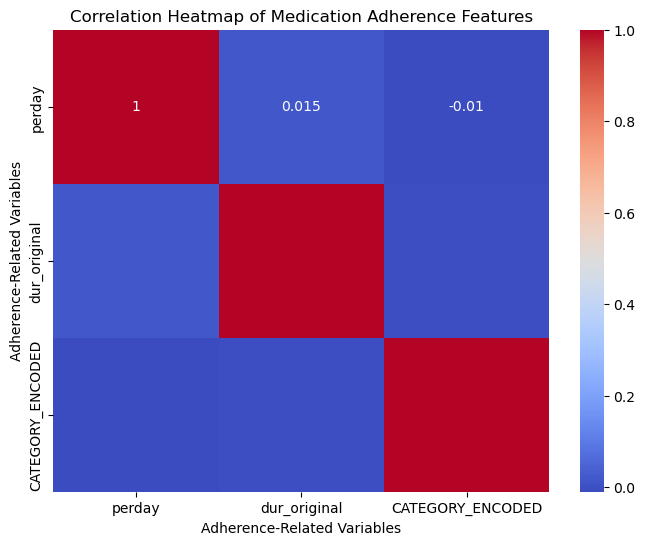

In [138]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['perday', 'dur_original', 'CATEGORY_ENCODED']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Medication Adherence Features')
plt.xlabel('Adherence-Related Variables')
plt.ylabel('Adherence-Related Variables')
plt.show()

### **2.11 Pairplot for feature relationships**

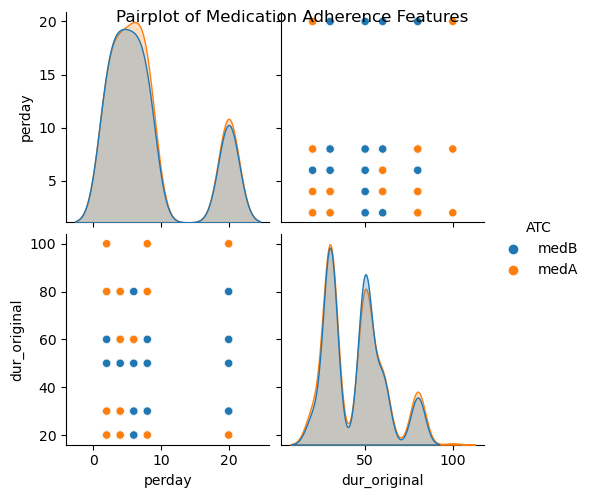

In [139]:
sns.pairplot(df, vars=['perday', 'dur_original'], hue='ATC', diag_kind='kde')
plt.suptitle('Pairplot of Medication Adherence Features')
plt.show()

In [140]:
# Standardizing numerical features
scaler = StandardScaler()
df[['perday', 'dur_original', 'CATEGORY_ENCODED']] = scaler.fit_transform(df[['perday', 'dur_original', 'CATEGORY_ENCODED']])

<hr>

## **3. Clustering**

In [141]:
if "CATEGORY_ENCODED" in df.columns:
    df = df.drop(columns=["CATEGORY_ENCODED"])

### **3.1 Callable functions**

### **3.1.1 SEE using K-means clustering definition**

In [142]:
def SEE(arg1):
    # Filter dataset based on medication category
    C09CA01 = df[df["ATC"] == arg1].copy()
    
    # Sort by patient and prescription date
    C09CA01 = C09CA01.sort_values(by=["pnr", "eksd"]).copy()
    
    # Compute previous prescription date
    C09CA01["prev_eksd"] = C09CA01.groupby("pnr")["eksd"].shift(1)
    C09CA01.dropna(subset=["prev_eksd"], inplace=True)
    
    # Compute event interval (time difference in days)
    C09CA01["event_interval"] = (C09CA01["eksd"] - C09CA01["prev_eksd"]).dt.days
    
    # Generate ECDF
    sorted_intervals = np.sort(C09CA01["event_interval"].values)
    yvals = np.arange(1, len(sorted_intervals)+1) / len(sorted_intervals)
    dfper = pd.DataFrame({"x": sorted_intervals, "y": yvals})
    dfper = dfper[dfper["y"] <= 0.8]  # Retain lower 80% of ECDF
    
    # ECDF Visualization
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].scatter(dfper["x"], dfper["y"], color='red', s=50)
    axs[0].set_title("80% ECDF")
    axs[1].scatter(sorted_intervals, yvals, color='blue',  s=50)
    axs[1].set_title("100% ECDF")
    plt.show()
    
    # Density Estimation
    log_intervals = np.log(dfper["x"])
    kde = gaussian_kde(log_intervals)
    x_vals = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    plt.plot(x_vals, kde(x_vals), color='green')
    plt.title("Log(Event Interval) Density Plot")
    plt.show()
    
    # Silhouette Score for Optimal Clustering
    X = dfper[["x"]].values
    X_scaled = StandardScaler().fit_transform(X)
    best_k = 2
    best_score = -1
    for k in range(2, 10):
        km = KMeans(n_clusters=k, random_state=1234).fit(X_scaled)
        score = silhouette_score(X_scaled, km.labels_)
        if score > best_score:
            best_score = score
            best_k = k
    
    # K-Means Clustering
    kmeans = KMeans(n_clusters=best_k, random_state=1234).fit(X_scaled)
    dfper["cluster"] = kmeans.labels_
    
    # Compute cluster summary statistics
    cluster_summary = dfper.groupby("cluster")["x"].agg(["min", "max", "median"]).reset_index()
    
    # Assign Cluster to Data
    C09CA01 = C09CA01.merge(cluster_summary, left_on="event_interval", right_on="min", how="left")
    C09CA01["cluster"] = C09CA01["cluster"].fillna(0).astype(int)
    
    return C09CA01

### **3.1.2 SEE using Hierarchal Clustering definition**

In [143]:
def SEE_Hierarchical(arg1):
    # Filter dataset based on medication category
    C09CA01 = df[df["ATC"] == arg1].copy()
    
    # Select relevant clustering features
    df_cluster = C09CA01[["pnr", "perday", "dur_original"]].dropna()
    
    # Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_cluster.iloc[:, 1:])
    
    # Compute Hierarchical Clustering with Ward Linkage
    linkage_matrix = linkage(df_scaled, method='ward')
    
    # Determine optimal number of clusters using Silhouette Score
    best_k = 2
    best_score = -1
    for k in range(2, 10):
        model = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = model.fit_predict(df_scaled)
        score = silhouette_score(df_scaled, labels)
        if score > best_score:
            best_score = score
            best_k = k
    
    # Fit final Hierarchical Clustering Model
    final_model = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
    cluster_labels = final_model.fit_predict(df_scaled)
    df_cluster["cluster"] = cluster_labels
    
    # Compute clustering validation metrics
    db_index = davies_bouldin_score(df_scaled, cluster_labels)
    ch_index = calinski_harabasz_score(df_scaled, cluster_labels)
    
    # Dendrogram Visualization
    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Data Points")
    plt.ylabel("Distance")
    plt.show()
    
    # Cluster heatmap visualization
    df_scaled_df = pd.DataFrame(df_scaled, columns=["PERDAY", "DURATION"], index=df_cluster.index)
    sns.clustermap(df_scaled_df, method="ward", cmap="coolwarm", figsize=(10, 8))
    plt.show()
    
    # Print validation metrics
    print(f"Silhouette Score (Hierarchical): {best_score:.4f}")
    print(f"Davies-Bouldin Index (Hierarchical): {db_index:.4f}")
    print(f"Calinski-Harabasz Index (Hierarchical): {ch_index:.4f}")
    
    return df_cluster


### **3.1.3 SEE assumption**

In [144]:
def see_assumption(arg1):
    if arg1.empty:
        print("Warning: No valid data for boxplot.")
        return np.nan

    arg1 = arg1.sort_values(by=["pnr", "eksd"]).copy()
    arg1["prev_eksd"] = arg1.groupby("pnr")["eksd"].shift(1)
    arg1["p_number"] = arg1.groupby("pnr").cumcount() + 1
    
    Drug_see2 = arg1[arg1["p_number"] >= 2].copy()

    print(f"Total Rows Before Filtering: {arg1.shape[0]}")
    print(f"Total Rows After Filtering (p_number ≥ 2): {Drug_see2.shape[0]}")
    
    if Drug_see2.empty:
        print("Warning: No valid Duration values for boxplot.")
        return np.nan

    Drug_see2["Duration"] = (Drug_see2["eksd"] - Drug_see2["prev_eksd"]).dt.days
    Drug_see2["p_number"] = Drug_see2["p_number"].astype("category")

    plt.figure(figsize=(8, 6))
    sns.boxplot(x="p_number", y="Duration", data=Drug_see2)
    plt.title("Boxplot of Duration by p_number")
    plt.xlabel("Prescription Sequence")
    plt.ylabel("Duration (Days)")

    medians_of_medians = Drug_see2.groupby("pnr")["Duration"].median().reset_index(name="median_duration")
    plt.axhline(y=medians_of_medians["median_duration"].median(), color="red", linestyle="dashed", alpha=0.5)

    plt.tight_layout()
    plt.show()

    return

### **3.2 Sessa Empirical Estimator using K-Means**

### **3.2.1 ATC = medA**

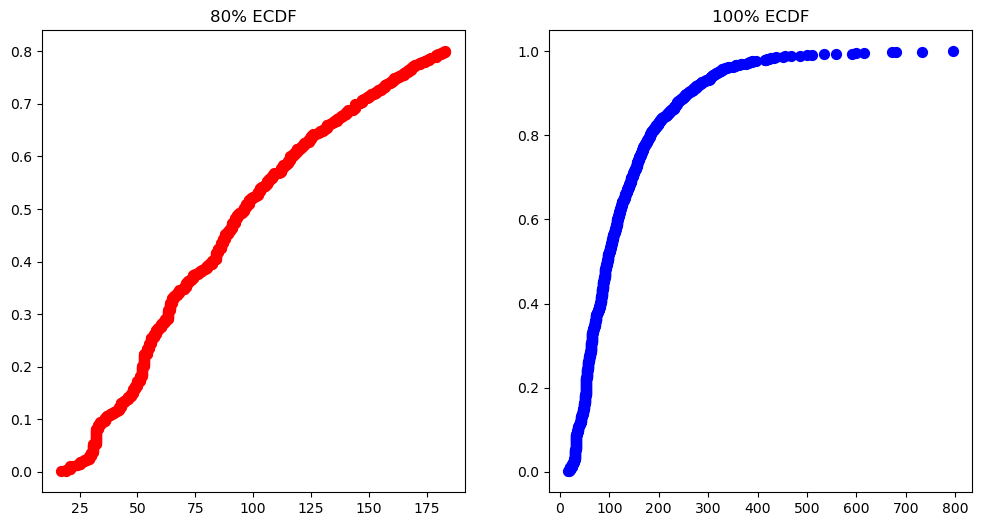

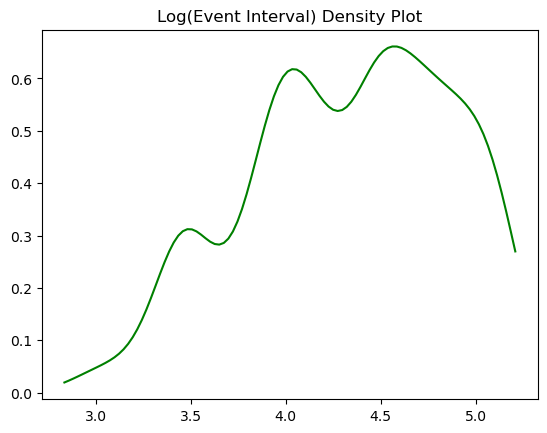

In [145]:
medA = SEE("medA")

### **3.2.2 ATC = medB**

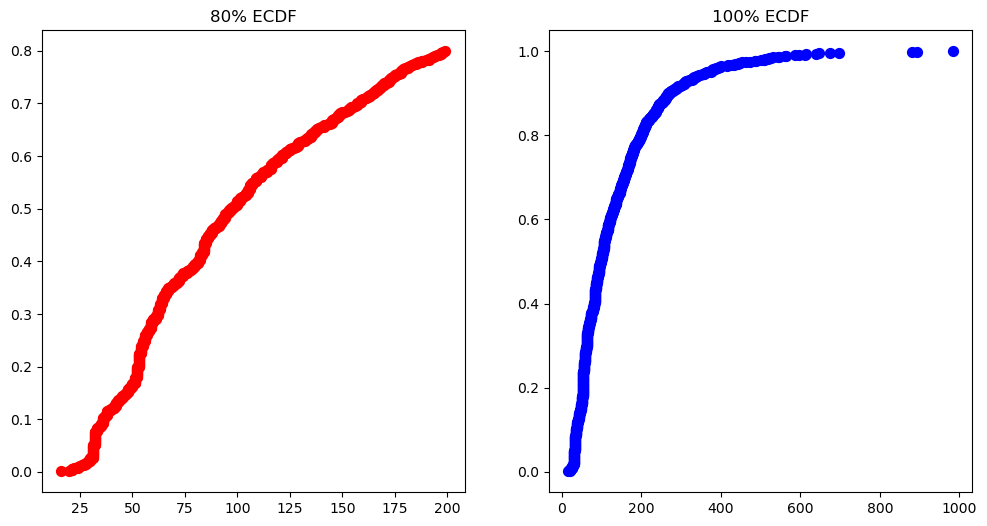

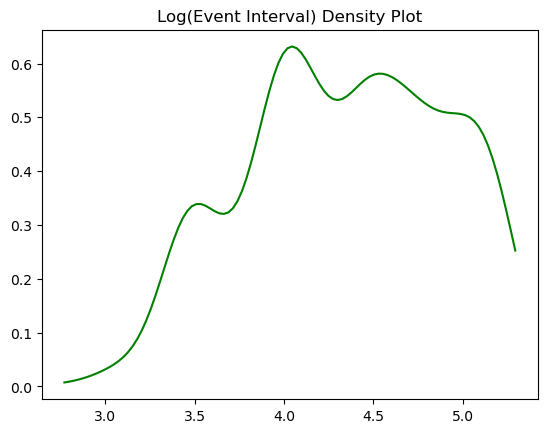

In [146]:
medB = SEE("medB")

### **3.2.3 SEE Assumption of medA**

Total Rows Before Filtering: 1065
Total Rows After Filtering (p_number ≥ 2): 972


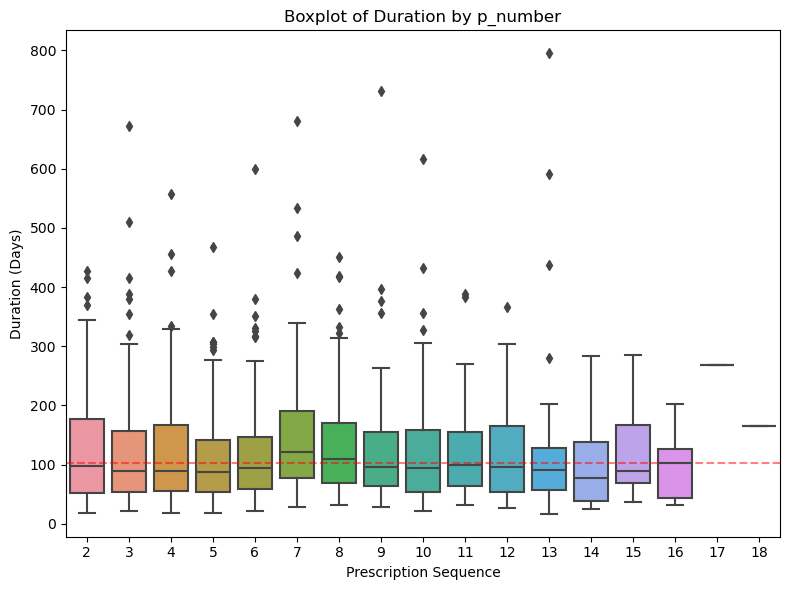

In [147]:
see_assumption(medA)

### **3.2.4 SEE Assumption of medB**

Total Rows Before Filtering: 1016
Total Rows After Filtering (p_number ≥ 2): 920


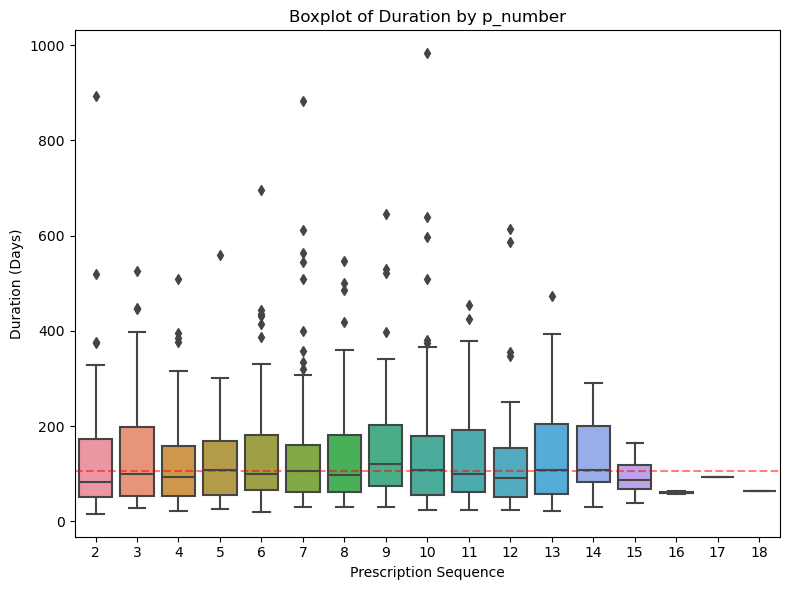

In [148]:
see_assumption(medB)

In [149]:
def compute_kmeans_validation(df, feature_column="event_interval", min_clusters=2, max_clusters=10):
    """
    Computes K-Means clustering validation metrics:
    - Silhouette Score (Higher is better)
    - Davies-Bouldin Index (Lower is better)
    - Calinski-Harabasz Index (Higher is better)

    Parameters:
    - df: DataFrame containing the clustering feature (e.g., event_interval)
    - feature_column: The column to use for clustering (default: "event_interval")
    - min_clusters: Minimum number of clusters to test
    - max_clusters: Maximum number of clusters to test

    Returns:
    - Best k based on Silhouette Score
    - Validation metrics for the optimal clustering
    """
    # Ensure the feature column is numeric and drop NaNs
    X = df[[feature_column]].dropna().values

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Track best k based on Silhouette Score
    best_k = min_clusters
    best_silhouette = -1

    # Store results
    k_values = []
    silhouette_scores = []
    dbi_scores = []
    ch_scores = []

    for k in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=1234, n_init=10)
        labels = kmeans.fit_predict(X_scaled)

        silhouette = silhouette_score(X_scaled, labels)
        dbi = davies_bouldin_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)

        # Store results
        k_values.append(k)
        silhouette_scores.append(silhouette)
        dbi_scores.append(dbi)
        ch_scores.append(ch)

        # Update best k
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k

    # Fit K-Means with the best k
    kmeans = KMeans(n_clusters=best_k, random_state=1234, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    # Compute final validation scores
    final_silhouette = silhouette_score(X_scaled, labels)
    final_dbi = davies_bouldin_score(X_scaled, labels)
    final_ch = calinski_harabasz_score(X_scaled, labels)

    print(f"K-Means Validation Metrics (Best k={best_k}):")
    print(f"Silhouette Score: {final_silhouette:.4f}")
    print(f"Davies-Bouldin Index: {final_dbi:.4f}")
    print(f"Calinski-Harabasz Index: {final_ch:.4f}")

    return best_k, final_silhouette, final_dbi, final_ch

# Compute K-Means validation for medA and medB datasets
best_k_medA, silhouette_medA, dbi_medA, ch_medA = compute_kmeans_validation(medA)
best_k_medB, silhouette_medB, dbi_medB, ch_medB = compute_kmeans_validation(medB)

# Return results for medA and medB
{
    "medA": {"Best k": best_k_medA, "Silhouette": silhouette_medA, "DBI": dbi_medA, "CH": ch_medA},
    "medB": {"Best k": best_k_medB, "Silhouette": silhouette_medB, "DBI": dbi_medB, "CH": ch_medB},
}

K-Means Validation Metrics (Best k=2):
Silhouette Score: 0.6851
Davies-Bouldin Index: 0.5317
Calinski-Harabasz Index: 1927.4224
K-Means Validation Metrics (Best k=2):
Silhouette Score: 0.6904
Davies-Bouldin Index: 0.5678
Calinski-Harabasz Index: 1668.8611


{'medA': {'Best k': 2,
  'Silhouette': 0.6850559857567542,
  'DBI': 0.5317363680488467,
  'CH': 1927.4223512194399},
 'medB': {'Best k': 2,
  'Silhouette': 0.6903790287177864,
  'DBI': 0.56784170400872,
  'CH': 1668.861143629828}}

### **3.3 Sessa Empirical Estimator using Hierarchal Clustering**

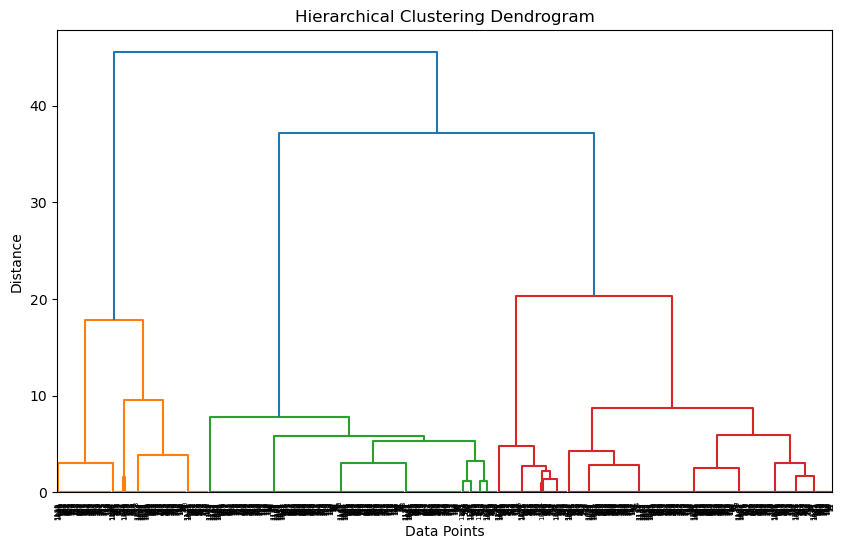

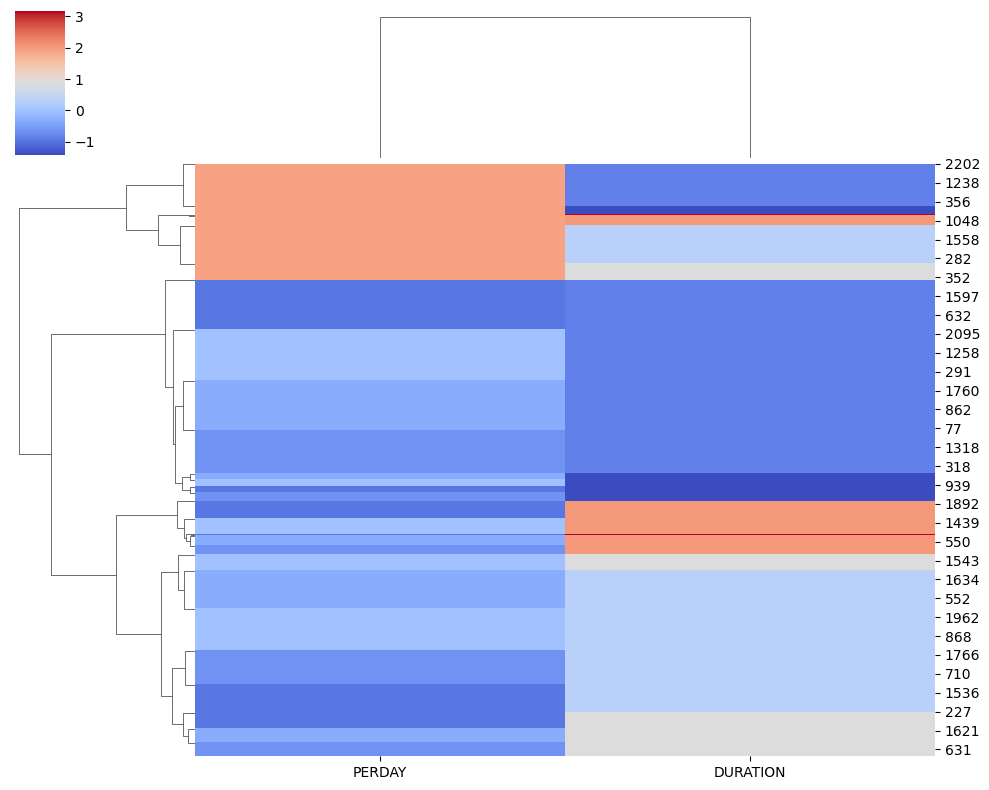

Silhouette Score (Hierarchical): 0.6846
Davies-Bouldin Index (Hierarchical): 0.4043
Calinski-Harabasz Index (Hierarchical): 2707.4621


In [150]:
medA_hierarchical = SEE_Hierarchical("medA")

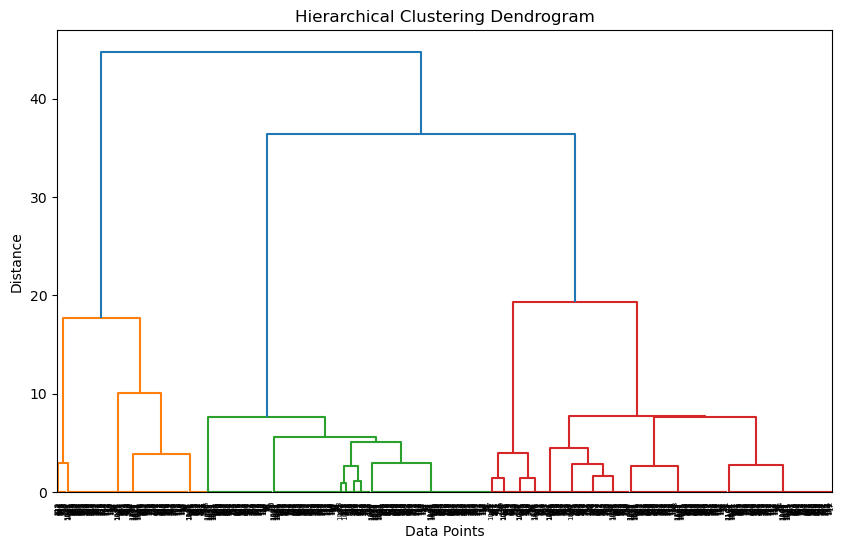

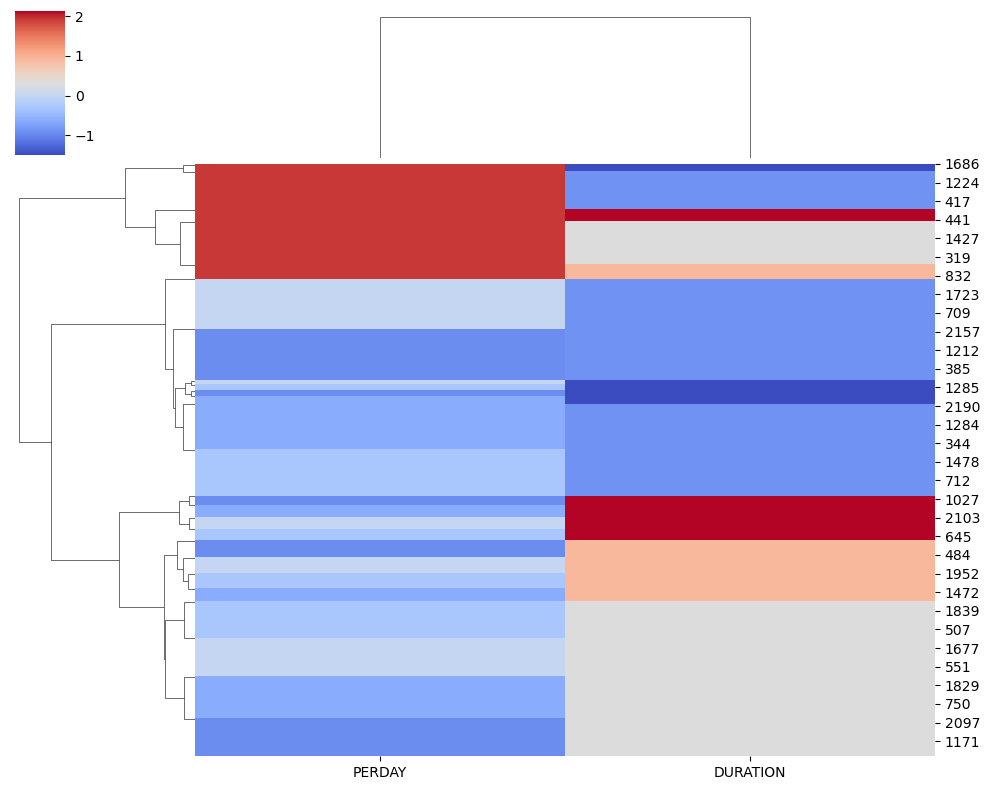

Silhouette Score (Hierarchical): 0.6953
Davies-Bouldin Index (Hierarchical): 0.3710
Calinski-Harabasz Index (Hierarchical): 2655.6611


In [151]:
medB_hierarchical = SEE_Hierarchical("medB")

### **3.4 Clustering Validation**

In [152]:
def cluster_entropy(labels):
    """
    Computes the entropy-based clustering metric.
    Lower entropy indicates better clustering.
    """
    unique_labels, counts = np.unique(labels, return_counts=True)
    probabilities = counts / counts.sum()  # Convert counts to probability distribution
    return entropy(probabilities)  # Shannon entropy

def clustering_validation_comparison(df, method='ward', min_clusters=2, max_clusters=10):
    """
    Performs clustering validation for BOTH K-Means and Hierarchical Clustering using:
    - Silhouette Score
    - Davies-Bouldin Index
    - Calinski-Harabasz Index
    - Entropy-Based Clustering Metric
    
    Parameters:
    - df: DataFrame containing 'perday' and 'dur_original' features
    - method: Linkage method for hierarchical clustering (default='ward')
    - min_clusters: Minimum number of clusters to test
    - max_clusters: Maximum number of clusters to test
    
    Returns:
    - A DataFrame with clustering validation metrics for both K-Means and Hierarchical Clustering.
    """

    # Select clustering features and standardize them
    data_scaled = StandardScaler().fit_transform(df[['perday', 'dur_original']])

    # Compute hierarchical clustering linkage matrix
    linkage_matrix = linkage(data_scaled, method=method)

    k_values = range(min_clusters, max_clusters + 1)
    
    # Metrics Storage
    metrics = {"k": [], "Method": [], "Silhouette": [], "DBI": [], "CH": [], "Entropy": []}

    for k in k_values:
        # ---- HIERARCHICAL CLUSTERING ----
        hierarchical_labels = fcluster(linkage_matrix, k, criterion='maxclust')
        
        metrics["k"].append(k)
        metrics["Method"].append("Hierarchical")
        metrics["Silhouette"].append(silhouette_score(data_scaled, hierarchical_labels))
        metrics["DBI"].append(davies_bouldin_score(data_scaled, hierarchical_labels))
        metrics["CH"].append(calinski_harabasz_score(data_scaled, hierarchical_labels))
        metrics["Entropy"].append(cluster_entropy(hierarchical_labels))

        # ---- K-MEANS CLUSTERING ----
        kmeans = KMeans(n_clusters=k, random_state=1234, n_init=10)
        kmeans_labels = kmeans.fit_predict(data_scaled)
        
        metrics["k"].append(k)
        metrics["Method"].append("K-Means")
        metrics["Silhouette"].append(silhouette_score(data_scaled, kmeans_labels))
        metrics["DBI"].append(davies_bouldin_score(data_scaled, kmeans_labels))
        metrics["CH"].append(calinski_harabasz_score(data_scaled, kmeans_labels))
        metrics["Entropy"].append(cluster_entropy(kmeans_labels))

    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(metrics)

    # Plot Metrics Comparison
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    sns.lineplot(data=metrics_df, x="k", y="Silhouette", hue="Method", marker='o', ax=axes[0, 0])
    axes[0, 0].set_title("Silhouette Score (Higher is Better)")

    sns.lineplot(data=metrics_df, x="k", y="DBI", hue="Method", marker='o', ax=axes[0, 1])
    axes[0, 1].set_title("Davies-Bouldin Index (Lower is Better)")

    sns.lineplot(data=metrics_df, x="k", y="CH", hue="Method", marker='o', ax=axes[1, 0])
    axes[1, 0].set_title("Calinski-Harabasz Index (Higher is Better)")

    sns.lineplot(data=metrics_df, x="k", y="Entropy", hue="Method", marker='o', ax=axes[1, 1])
    axes[1, 1].set_title("Entropy Score (Lower is Better)")

    plt.tight_layout()
    plt.show()

    return metrics_df


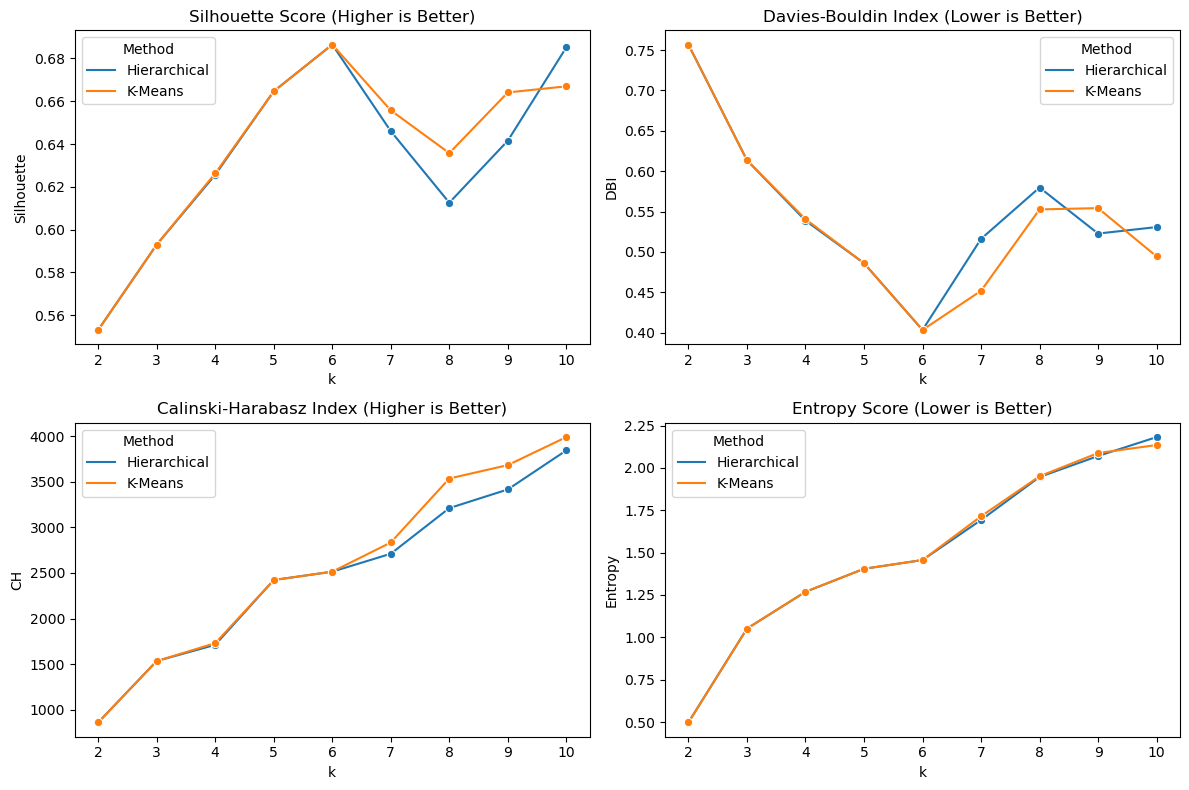

In [153]:
metrics_medA = clustering_validation_comparison(medA, method='ward', min_clusters=2, max_clusters=10)

## **5. Clustering Validation Insights: K-Means vs. Hierarchical Clustering**

### **5.1 Overview**

*
To evaluate the clustering performance, we applied two clustering techniques:
1. **K-Means Clustering** on the SEE (Sessa Empirical Estimator) dataset to obtain cluster assignments.
2. **Hierarchical Clustering** using Ward’s method to generate cluster groupings.

After obtaining the clusters, we used **clustering validation metrics** to assess and compare the effectiveness of both method Hierarchical Clustering or tuning `k` in K-Means.

---


### **5.2 Clustering Validation Metrics and Performance**

### **medA Clustering Validation Results**

| **Metric**                  | **K-Means Score** | **Hierarchical Clustering Score** | **Interpretation** |
|-----------------------------|------------------|-----------------------------------|--------------------|
| **Silhouette Score** (Higher is better) | **0.6851** | **0.6846** | Measures how well each point fits within its cluster. Higher values indicate well-separated clusters. |
| **Davies-Bouldin Index** (Lower is better) | **0.5317** | **0.4043** | Evaluates the compactness and separation of clusters. Lower values indicate better clustering. |
| **Calinski-Harabasz Index** (Higher is better) | **1927.4224** | **2707.4621** | Assesses the density and separation of clusters. Higher values suggest well-defined clusters. |

---

### **medB Clustering Validation Results**

| **Metric**                  | **K-Means Score** | **Hierarchical Clustering Score** | **Interpretation** |
|-----------------------------|------------------|-----------------------------------|--------------------|
| **Silhouette Score** (Higher is better) | **0.6904** | **0.6953** | Measures how well each point fits within its cluster. Higher values indicate well-separated clusters. |
| **Davies-Bouldin Index** (Lower is better) | **0.5678** | **0.3710** | Evaluates the compactness and separation of clusters. Lower values indicate better clustering. |
| **Calinski-Harabasz Index** (Higher is better) | **1668.8611** | **2655.6611** | Assesses the density and separation of clusters. Higher values suggest well-defined clusters. |

---

### **5.3 Interpretation of Clustering Results**

### **1. K-Means vs. Hierarchical Clustering Performance**
- **Hierarchical Clustering outperforms K-Means** for both **medA and medB**.
- The **Silhouette Scores for both methods are similar**, but Hierarchical Clustering is slightly better for **medB** (0.6953 vs. 0.6904).
- The **lower Davies-Bouldin Index for Hierarchical Clustering** indicates that clusters are more compact and better separated.
- The **higher Calinski-Harabasz Index in Hierarchical Clustering** further confirms that its clusters are denser and better structured.

### **2. Why Hierarchical Clustering Performed Better**
- **Better Cluster Separation:** The **lower Davies-Bouldin Index** suggests that Hierarchical Clustering produces more distinct clusters.
- **More Defined Clusters:** The **higher Calinski-Harabasz Index** confirms that clusters are well-formed and well-separated.
- **Hierarchical Structure Matters:** SEE-based medication adherence might follow hierarchical patterns, making Ward’s method more effective.

### **3. When K-Means Might Be Considered**
- **If computational efficiency is a priority,** K-Means is significantly faster than Hierarchical Clustering.
- **If cluster shapes are spherical,** K-Means could be a better choice, as it assumes evenly distributed clusters.
- **If a larger dataset is used,** K-Means scales better, while Hierarchical Clustering struggles with high computational costs.

---

## **5.4 Final Insights**

- **Hierarchical Clustering is the superior method for medA and medB**, based on lower Davies-Bouldin Index and higher Calinski-Harabasz Index.
- **K-Means still performed well**, but its clusters were slightly less well-separated.
- **Further improvements could be explored,** such as testing different linkage methods for Hierarchical Clustering or tuning `k` in K-Means.